In [1]:
import os, glob, time

start = time.time()

import numpy as np
import cv2
from keras.models import load_model

DEFECT_LIST = ['none', 'chipping']
DEFECT_MAPPING = dict(enumerate(DEFECT_LIST))
IMG_SIZE = 256

chipping = [5763, 5764, 6824, 6825]

print('loading model...')
model = load_model('models/vgg16-99.91.h5')

paths = os.path.join(os.getcwd(), 'klarf-EN', 'new')

print('loading images...')
x_test, y_test = [], []
for path in glob.glob(os.path.join(paths, '*')):
    img = cv2.imread(path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    x_test.append(img)
    if int(path.split('-')[-1].split('.')[0]) in chipping:
        y_test.append(1)
    else:
        y_test.append(0)

print(f'loaded {len(y_test)} images, predicting...')

x_test = np.array(x_test)
pred = model.predict(x_test, batch_size=32)
pred = np.argmax(pred, axis=1).tolist()

corrects = [1 if y_test[i] == pred[i] else 0 for i in range(len(y_test))]
acc = sum(corrects)/len(y_test)*100

print(f'{(time.time() - start)/60:.2f} mins')
print(acc)

loading model...
loading images...
loaded 2574 images, predicting...
12.25 mins
99.3006993006993


In [3]:
incorrects = [i+5756 for i in range(len(corrects)) if corrects[i] == 0]
print(incorrects)

[5764, 5798, 5799, 6083, 6190, 6488, 6496, 6542, 6641, 6801, 6808, 6824, 6825, 7478, 7705, 7714, 7812, 8261]


In [4]:
len(incorrects)

18

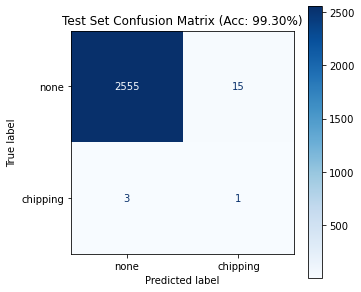

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=DEFECT_LIST)

fig, ax = plt.subplots(figsize=(5,5))
ax.set_title(f'Test Set Confusion Matrix (Acc: {acc:.2f}%)')

disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

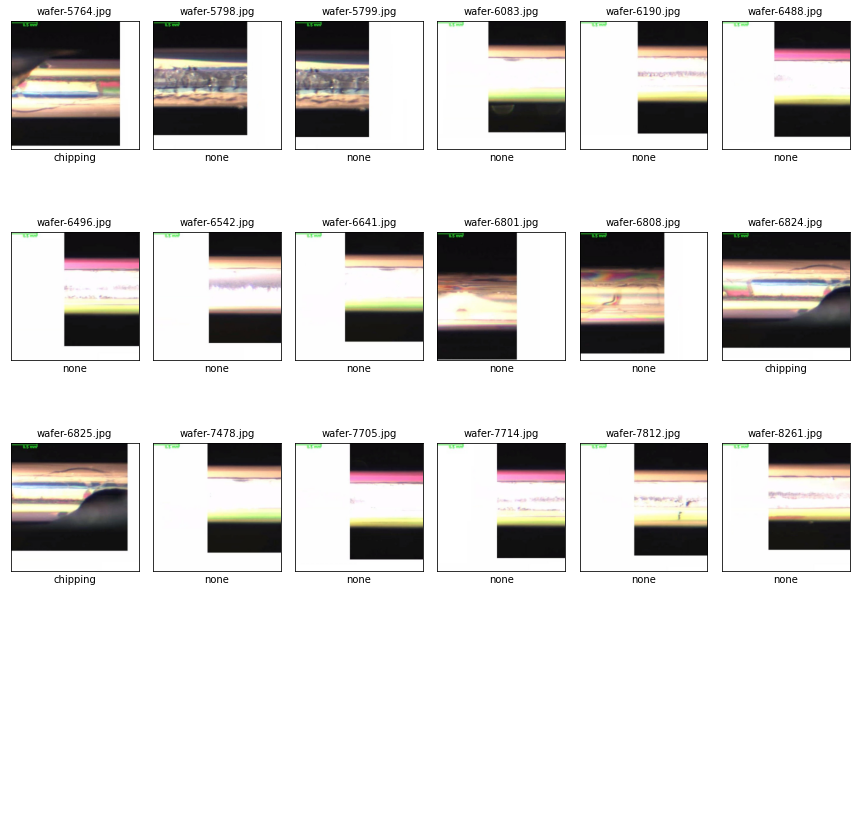

In [7]:
fig, ax = plt.subplots(nrows=len(incorrects)//6+1, ncols=6, figsize=(12, 12))
ax = ax.ravel(order='C')
for a in ax: a.set_axis_off()
i = 0
for none_img in glob.glob(os.path.join(os.getcwd(), 'klarf-EN', 'new', '*')):
    wafernum = int(none_img.split('-')[-1].split('.')[0])
    if wafernum in incorrects:
        img = cv2.imread(none_img, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0
        ax[i].imshow(img)
        ax[i].set_axis_on()
        ax[i].set_title(f'wafer-{none_img.split("-")[-1]}', fontsize=10)
        if wafernum in chipping: ax[i].set_xlabel('chipping', fontsize=10)
        else: ax[i].set_xlabel('none', fontsize=10)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        i += 1

plt.tight_layout()
plt.show()